# Explore GAA2 Data
The second Global Amphibian Acessment (GAA2) completed in June 2022 and acesses 8,011 species aswell as backcasting redlist categorization for 1980 and 2004. 

**An overview of the IUCN Red List criteria**
<img src="images/redlist_criteria_2022.png" />

*For explanations of terms and concepts in this summary, see: IUCN Standards and Petitions Committee. 2022. Guidelines for Using the IUCN Red List Categories and Criteria. Version 15.1. Prepared by the Standards and Petitions Committee. Downloadable from https://www.iucnredlist.org/documents/RedListGuidelines.pdf*

For extinction risk modeling based on geographic ranges, the **criteria B and E** might be especially interesting. However, it is important to note that red list categorizations are based on a complicated process that may not fully be representable by a simple model. 

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
from netCDF4 import Dataset
import glob
import sys
import math
import matplotlib.pyplot as plt

In [11]:
# load spacial data 
# gaa2 = gpd.read_file('../Data/GAA2/GAA2_allspecies.gdb')
# load spacial data - first 10 rows only
gaa2 = gpd.read_file('../Data/GAA2/GAA2_allspecies.gdb', rows=10)

In [12]:
gaa2.head()

,sci_name,presence,origin,seasonal,compiler,yrcompiled,citation,generalisd,legend,Shape_Length,Shape_Area,geometry
0,Agalychnis medinae,4,1,1,Grisel Velasquez,2020,IUCN (International Union for Conservation of ...,0,Possibly Extinct,0.370600,0.002628,"MULTIPOLYGON (((-67.68359 10.33905, -67.69001 ..."
1,Agalychnis medinae,1,1,1,Grisel Velasquez,2020,IUCN (International Union for Conservation of ...,0,Extant (resident),12.037778,0.052403,"MULTIPOLYGON (((-68.19222 10.37306, -68.19222 ..."
2,Telmatobius mendelsoni,4,1,1,Kelsey Neam,2017,IUCN (International Union for Conservation of ...,0,Possibly Extinct,0.497784,0.010478,"MULTIPOLYGON (((-71.58104 -13.20094, -71.58300..."
3,Thorius omiltemi,1,1,1,Lauren Warr,2019,IUCN (International Union for Conservation of ...,0,Extant (resident),0.842579,0.010135,"MULTIPOLYGON (((-99.83744 17.62612, -99.83715 ..."
4,Ptychadena perplicata,1,1,1,Evie J Morris,2013,IUCN (International Union for Conservation of ...,0,Extant (resident),35.864748,55.708237,"MULTIPOLYGON (((14.33262 -13.91498, 14.33160 -..."


In [13]:
gaa2.iloc[[4]].bounds.values[0]

array([ 14.21243235, -14.04298655,  29.88072844,  -7.44900973])

In [14]:
# load test geometry
geo = gaa2.iloc[[4]]

# Explore Human Preassure maps
1 km resolution human footprint maps: Values from 1-10 for (1) built environments, (2) population density, (3) electric infrastructure, (4) crop lands, (5) pasture lands, (6) roads, (7) railways, and (8) navigable waterways

1993 and 2009: Venter et al. (2016), Nature
https://www.nature.com/articles/sdata201667

Yearly 2000 - 2018 Mu et al. (2022), Nature
https://www.nature.com/articles/s41597-022-01284-8

In [117]:
import xarray as xr
import rioxarray as rxr

# load urban areas, cropland pastures
urban = xr.open_dataset("../Data/HYDE_landuse_pop_1901_2021/landuse-urbanareas_histsoc_annual_1901_2021.nc", decode_coords="all", decode_times=False)
crop = xr.open_dataset("../Data/HYDE_landuse_pop_1901_2021/landuse-totals_histsoc_annual_1901_2021.nc", decode_coords="all", decode_times=False)
pasture = xr.open_dataset("../Data/HYDE_landuse_pop_1901_2021/landuse-pastures_histsoc_annual_1901_2021.nc", decode_coords="all", decode_times=False)

# normalize the years 1901 - 2021
urban['time'] = (urban['time'] + 1901 - pasture['time'][0]).astype(int)
crop['time'] = (crop['time'] + 1901 - pasture['time'][0]).astype(int)
pasture['time'] = (pasture['time'] + 1901 - pasture['time'][0]).astype(int)

# write crs WSG 84 (lon, lat)
urban = urban.rio.write_crs("EPSG:4326")
crop = crop.rio.write_crs("EPSG:4326")
pasture = pasture.rio.write_crs("EPSG:4326")

# reproject everything to Lambert Cylindrical Equal Area (CEA) projection, following Lucas et al., 2023
# https://www.biorxiv.org/content/10.1101/2023.02.08.526823v1.full#ref-34
urban = urban.rio.reproject("EPSG:6933")
crop = crop.rio.reproject("EPSG:6933")
pasture = pasture.rio.reproject("EPSG:6933")

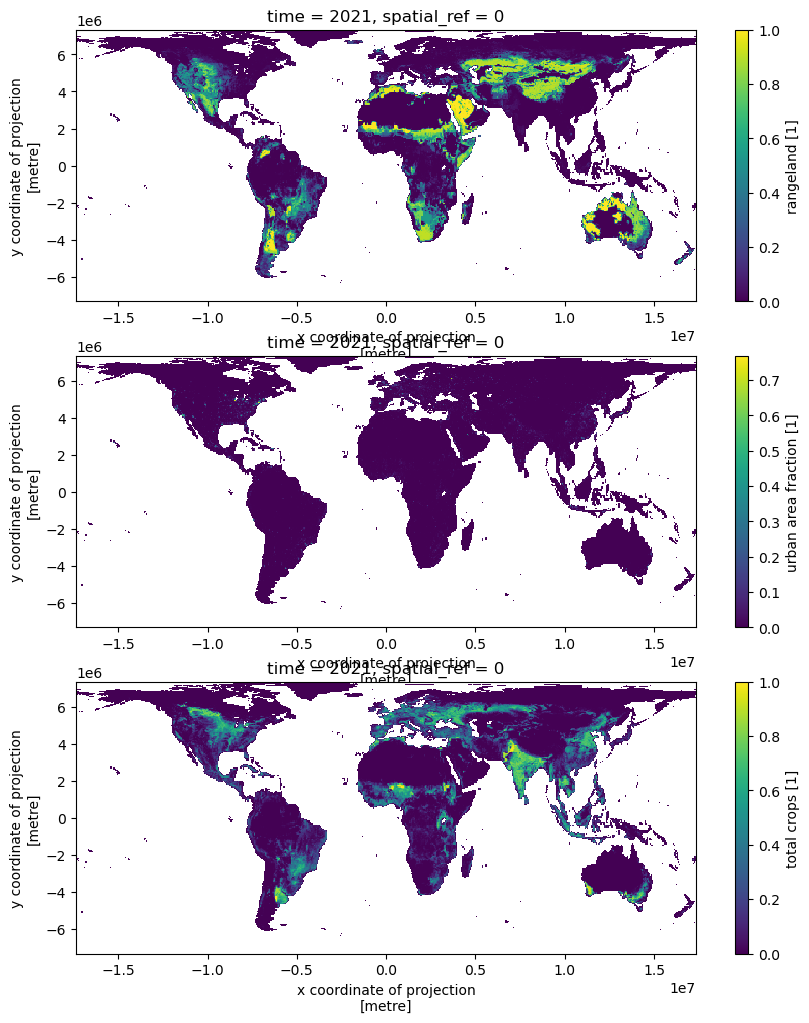

In [119]:
# plot 2021
plt.figure(figsize=(10,12))
plt.subplot(3,1,1)
pasture.sel(time=2021).rangeland.plot.imshow(cmap='viridis', add_colorbar=True)
plt.subplot(3,1,2)
urban.sel(time=2021).urbanareas.plot.imshow(cmap='viridis', add_colorbar=True)
plt.subplot(3,1,3)
crop.sel(time=2021).cropland_total.plot.imshow(cmap='viridis', add_colorbar=True)


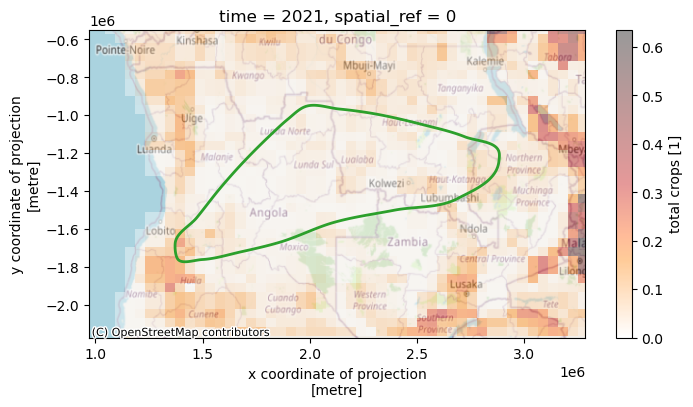

In [266]:
# reproject example geometry
geo = geo.to_crs("EPSG:6933")

# get the fractional cropland cover for the window of the geometry
margin = 400000
xmin, ymin, xmax, ymax = geo.bounds.values[0]
xmin -= margin
ymin -= margin
xmax += margin
ymax += margin

crop21 = crop.sel(time=2021).cropland_total
dat_window = crop21.sel(x = slice(xmin, xmax), y = slice(ymax, ymin))

# plot geometry and landuse with basemap
import contextily as ctx

fig, ax = plt.subplots(figsize=(8,4))
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
geo.plot(ax=ax, facecolor='none', edgecolor='tab:green', linewidth=2)
ctx.add_basemap(ax=ax, crs=geo.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
dat_window.plot.imshow(ax=ax, alpha = 0.4, cmap='gist_heat_r')

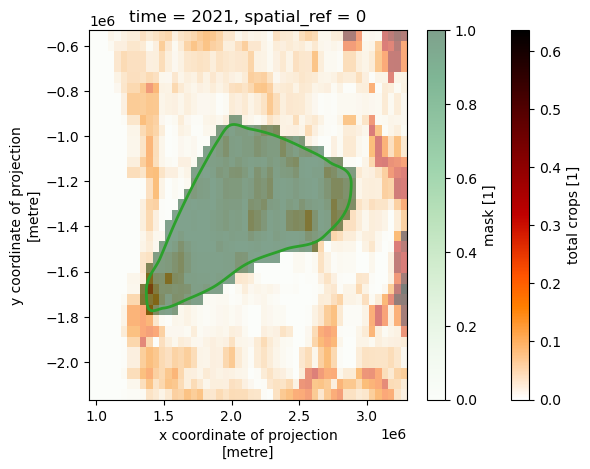

In [270]:
# rasterize the polygon according to window
from rasterio.features import rasterize
poly = geo['geometry'].iloc[0]
mask = rasterize([(poly)],
                transform=dat_window.rio.transform(),
                out_shape=dat_window.shape, 
                all_touched=True)

# copy array to xarray with appropiate coordinates and crs (improvised version)
mask2 = dat_window.copy()
mask2.attrs['long_name'] = 'mask'
mask2.values = mask

# visualize
fig, ax = plt.subplots()
geo.plot(ax=ax, facecolor='none', edgecolor='tab:green', linewidth=2)
dat_window.plot.imshow(ax=ax, cmap='gist_heat_r')
mask2.plot.imshow(ax=ax, alpha= 0.5, cmap='Greens')

In [283]:
# calculate the percentage of range size covered by crops
# assuming that each grid cell has the same area.

dat_window_filled = dat_window.fillna(0)
cropcover_percentage = np.sum(mask2.values * dat_window_filled.values) / np.sum(mask2.values)
cropcover_percentage

0.02224566791597651